# Quantile Regression

In traditional linear regression, we attempt to model the conditional mean by assuming that error are normally distributed with zero mean and constant variance.

$$ \epsilon \sim N(0, \sigma^2)$$

Unfortunately real world data are usually not normally distributed, a lot of time data are heteroskedastic, there are lots of outliers and may follow some special distributions. In this case, linear regression may not be the best model to use.

Quantile regression is a useful alternative to linear regression when the data are not normally distributed. Quantile regression models the conditional median (or any other quantile) of the response variable instead of the conditional mean - it models the conditional distribution instead of just the conditional mean. 

Let's look at some examples to see why may we want to use quantile regression.


# Examples of when Quantile Regression is useful

### Heteroskedasticity

Notice how quantile regression accurately capture the heteroskedasticity by estimating conditional quantiles seperately

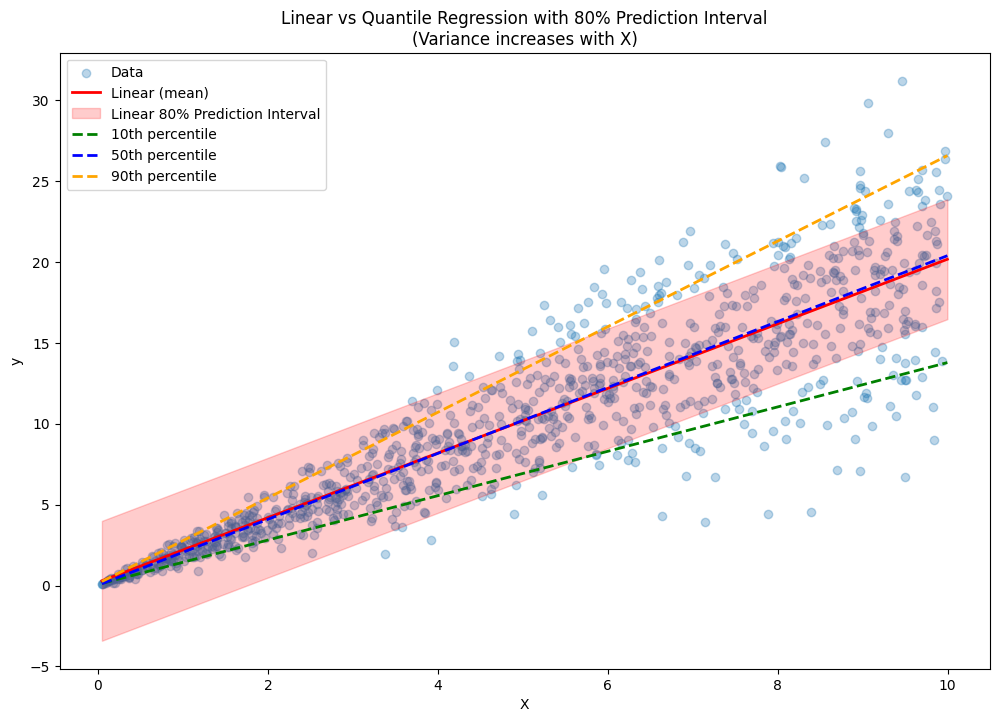

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg
from scipy import stats

# Generate data with heteroskedasticity
np.random.seed(42)
n = 1000
X = np.random.uniform(0, 10, n)
y = 2 * X + X * np.random.normal(0, 0.5, n)  # Variance increases with X
X_with_const = sm.add_constant(X)

# Linear regression (mean)
linear_model = sm.OLS(y, X_with_const).fit()

# Quantile regression for different quantiles
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}
for q in quantiles:
    quantile_models[q] = QuantReg(y, X_with_const).fit(q=q)

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(X, y, alpha=0.3, label='Data')

# Plot linear regression
X_sorted = np.sort(X)
X_sorted_with_const = sm.add_constant(X_sorted)
linear_pred = linear_model.predict(X_sorted_with_const)
plt.plot(X_sorted, linear_pred, 'r-', linewidth=2, label='Linear (mean)')

# Add 80% prediction interval for linear regression
# Prediction interval includes both uncertainty in the mean AND the error variance
linear_se = np.sqrt(linear_model.mse_resid * (1 + 1/n + (X_sorted - X.mean())**2 / np.sum((X - X.mean())**2)))
z_crit = stats.norm.ppf(0.90)  # 80% prediction interval (two-tailed)
pi_lower = linear_pred - z_crit * linear_se
pi_upper = linear_pred + z_crit * linear_se
plt.fill_between(X_sorted, pi_lower, pi_upper, color='red', alpha=0.2, label='Linear 80% Prediction Interval')

colors = ['g', 'b', 'orange']
for i, (q, model) in enumerate(quantile_models.items()):
    plt.plot(X_sorted, model.predict(X_sorted_with_const), 
             color=colors[i], linewidth=2, 
             linestyle='--', label=f'{int(q*100)}th percentile')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear vs Quantile Regression with 80% Prediction Interval\n(Variance increases with X)')
plt.legend()
plt.show()

### Skewed distribution for error (Not normal)

Notice how quantile regression can accurate capture the skewness by running estimation on individual conditional quantile as opposed to just a conditional mean with symmetric boundary on both side

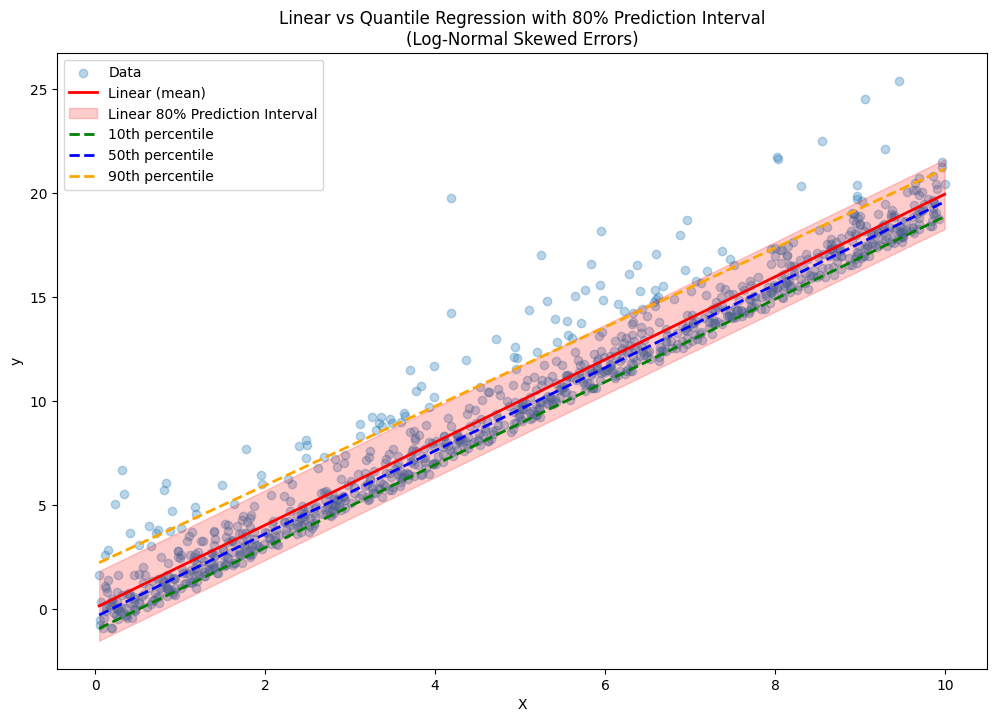

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg
from scipy import stats

# Generate data with skewed errors (log-normal distribution)
np.random.seed(42)
n = 1000
X = np.random.uniform(0, 10, n)

# Generate skewed errors from log-normal distribution
skewed_errors = np.random.lognormal(mean=0, sigma=0.8, size=n)
# Center the errors to have mean approximately 0
skewed_errors = skewed_errors - np.mean(skewed_errors)

# Generate y with skewed errors (constant variance, but skewed distribution)
y = 2 * X + skewed_errors

X_with_const = sm.add_constant(X)

# Linear regression (mean)
linear_model = sm.OLS(y, X_with_const).fit()

# Quantile regression for different quantiles
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}
for q in quantiles:
    quantile_models[q] = QuantReg(y, X_with_const).fit(q=q)

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(X, y, alpha=0.3, label='Data')

# Plot linear regression
X_sorted = np.sort(X)
X_sorted_with_const = sm.add_constant(X_sorted)
linear_pred = linear_model.predict(X_sorted_with_const)
plt.plot(X_sorted, linear_pred, 'r-', linewidth=2, label='Linear (mean)')

# Add 80% prediction interval for linear regression
linear_se = np.sqrt(linear_model.mse_resid * (1 + 1/n + (X_sorted - X.mean())**2 / np.sum((X - X.mean())**2)))
z_crit = stats.norm.ppf(0.90)  # 80% prediction interval (two-tailed)
pi_lower = linear_pred - z_crit * linear_se
pi_upper = linear_pred + z_crit * linear_se
plt.fill_between(X_sorted, pi_lower, pi_upper, color='red', alpha=0.2, label='Linear 80% Prediction Interval')

colors = ['g', 'b', 'orange']
for i, (q, model) in enumerate(quantile_models.items()):
    plt.plot(X_sorted, model.predict(X_sorted_with_const), 
             color=colors[i], linewidth=2, 
             linestyle='--', label=f'{int(q*100)}th percentile')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear vs Quantile Regression with 80% Prediction Interval\n(Log-Normal Skewed Errors)')
plt.legend()
plt.show()

### Special distributions (Cauchy - undefined expected value and variance)

Notice how linear regression completely crumble but quantile regression still prevails

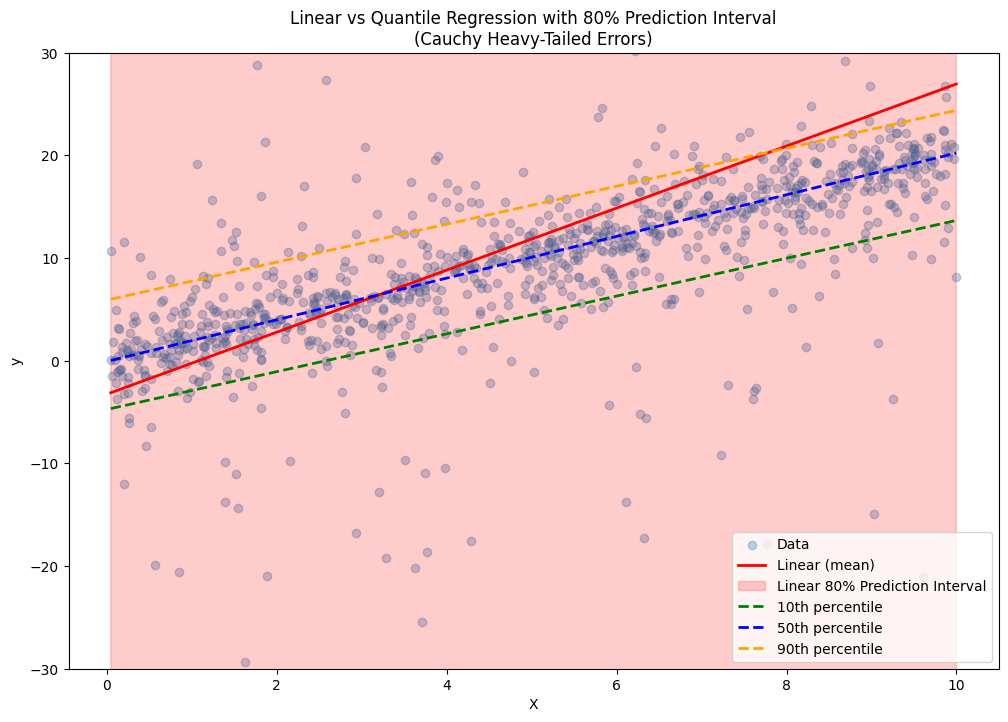

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg
from scipy import stats

# Generate data with Cauchy errors (heavy-tailed distribution)
np.random.seed(42)
n = 1000
X = np.random.uniform(0, 10, n)

# Generate errors from Cauchy distribution
# Cauchy has no finite mean or variance - extreme outliers are common
cauchy_errors = np.random.standard_cauchy(size=n) * 2  # Scale factor 2

# Generate y with Cauchy errors
y = 2 * X + cauchy_errors

X_with_const = sm.add_constant(X)

# Linear regression (mean)
linear_model = sm.OLS(y, X_with_const).fit()

# Quantile regression for different quantiles
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}
for q in quantiles:
    quantile_models[q] = QuantReg(y, X_with_const).fit(q=q)

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(X, y, alpha=0.3, label='Data')

# Plot linear regression
X_sorted = np.sort(X)
X_sorted_with_const = sm.add_constant(X_sorted)
linear_pred = linear_model.predict(X_sorted_with_const)
plt.plot(X_sorted, linear_pred, 'r-', linewidth=2, label='Linear (mean)')

# Add 80% prediction interval for linear regression
linear_se = np.sqrt(linear_model.mse_resid * (1 + 1/n + (X_sorted - X.mean())**2 / np.sum((X - X.mean())**2)))
z_crit = stats.norm.ppf(0.90)  # 80% prediction interval (two-tailed)
pi_lower = linear_pred - z_crit * linear_se
pi_upper = linear_pred + z_crit * linear_se
plt.fill_between(X_sorted, pi_lower, pi_upper, color='red', alpha=0.2, label='Linear 80% Prediction Interval')

colors = ['g', 'b', 'orange']
for i, (q, model) in enumerate(quantile_models.items()):
    plt.plot(X_sorted, model.predict(X_sorted_with_const), 
             color=colors[i], linewidth=2, 
             linestyle='--', label=f'{int(q*100)}th percentile')

# Set y-limits to make plot readable (Cauchy produces extreme outliers)
plt.ylim(-30, 30)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear vs Quantile Regression with 80% Prediction Interval\n(Cauchy Heavy-Tailed Errors)')
plt.legend()
plt.show()

## Prediction Interval vs Confidence Interval

We compare the prediction interval derived from linear regression with the quantile estimated with a quantile regression model. We can clearly see how quantile regression provides a more robust estimate of the conditional distribution of the response variable.

Noted that **confidence intervals (CI)** estimate the range for the mean response, whereas **prediction intervals (PI)** predict the range for a single, new observation.

The formula for prediction interval is 
$$x_0^T\hat{\beta} \pm t_{n-p, \alpha /2}\hat{\sigma}\sqrt{1+x_0^T(X^TX)^{-1}x_0}$$

The formula for confidence interval is 
$$x_0^T\hat{\beta} \pm t_{n-p, \alpha /2}\hat{\sigma}\sqrt{x_0^T(X^TX)^{-1}x_0}$$

The difference is just the 1 inside the sqrt, noted that prediction interval is always wider than confidence interval, which make sense as we are modelling the variance of $x_0\beta+\epsilon$ as opposed to only modelling the variance of $x_0\beta$. There is additional variance to consider for the error term, which is actually the only difference between the two intervals.




# Quantile Regression

The difference between quantile regression and linear regression lies solely on the loss function. In quantile regression, a **pinball loss function** is used, defined as 
$$\rho_\tau(u) = u(\tau - I(u<0))$$


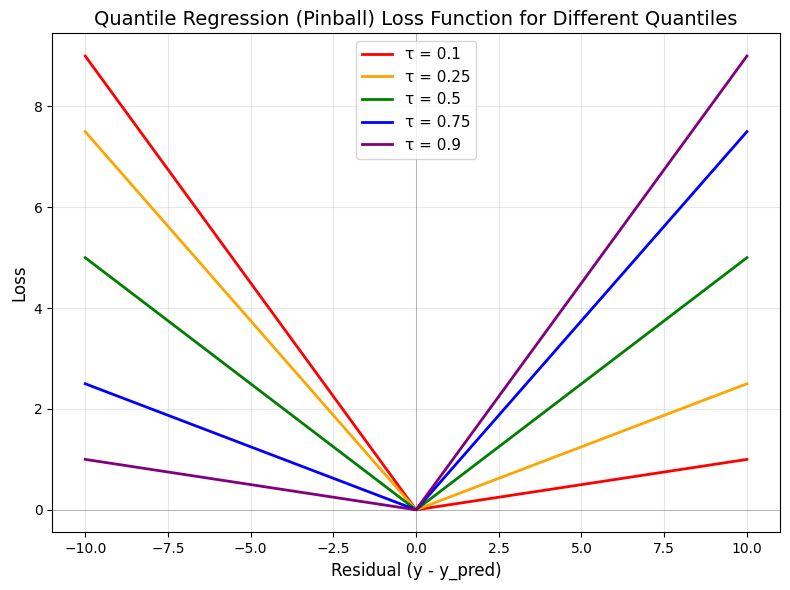

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def pinball_loss(residual, tau):
    """
    Compute the pinball loss for a given residual and quantile tau.
    
    Parameters:
    residual: The difference between actual and predicted values (y - y_pred)
    tau: The quantile of interest (between 0 and 1)
    """
    if residual >= 0:
        return tau * residual
    else:
        return (tau - 1) * residual  # equivalent to (1 - tau) * |residual| for negative values

# Create a range of residuals from -10 to 10
residuals = np.linspace(-10, 10, 1000)

# Different quantiles to visualize
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
colors = ['red', 'orange', 'green', 'blue', 'purple']

# Create the plot
plt.figure(figsize=(8, 6))

# Calculate and plot loss for each quantile
for tau, color in zip(quantiles, colors):
    losses = [pinball_loss(r, tau) for r in residuals]
    plt.plot(residuals, losses, color=color, linewidth=2, 
             label=f'τ = {tau}')

# Add labels and title
plt.xlabel('Residual (y - y_pred)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Quantile Regression (Pinball) Loss Function for Different Quantiles', 
          fontsize=14)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

We can try to reason the loss function intuitively. 

Consider the example where we are trying to model the conditional 0.25 quantile (lower quantile), the yellow line.

Notice how it gives more loss to points lying under our regression line and give less loss to points lying above our regression line. Essentially what the loss function is doing is to weight each point such that at the end of the optimization process, there will be 25% of the points lying below the regression line and 75% of points lying above the regression line.

So now we are left with the optimization problem 

$$\hat{\beta}(\tau) = \arg\min_{\beta \in \mathbb{R}^p} \left[ \sum_{i: y_i \ge x_i^T \beta} \tau |y_i - x_i^T \beta| + \sum_{i: y_i < x_i^T \beta} (1 - \tau) |y_i - x_i^T \beta| \right]$$

which does not have a closed-form solution unlike linear regression, but can be solved with different linear programming approaches such as simplex method and interior point methods.

### Derivation of the Quantile Loss Function

We want to find a prediction $\hat{y}$ that minimizes the expected loss for a given quantile $\tau \in (0,1)$.

**Step 1: Define asymmetric absolute loss**

Define a loss function that penalizes overprediction and underprediction differently:

$$ L_\tau(y, \hat{y}) = \begin{cases} 
c_1 |y - \hat{y}| & \text{if } y \ge \hat{y} \text{ (underprediction)} \\
c_2 |y - \hat{y}| & \text{if } y < \hat{y} \text{ (overprediction)}
\end{cases} $$

where $c_1$ and $c_2$ are positive constants to be determined.

**Step 2: Express expected loss**

The expected loss is:

$$ E[L_\tau(Y, \hat{y})] = c_1 \int_{\hat{y}}^{\infty} (y - \hat{y}) f_Y(y) \, dy + c_2 \int_{-\infty}^{\hat{y}} (\hat{y} - y) f_Y(y) \, dy $$

where $f_Y(y)$ is the probability density function of $Y$.

**Step 3: Take derivative with respect to $\hat{y}$**

Using Leibniz's rule for differentiation under the integral sign:

$$ \frac{\partial}{\partial \hat{y}} E[L_\tau] = -c_1 \int_{\hat{y}}^{\infty} f_Y(y) \, dy + c_2 \int_{-\infty}^{\hat{y}} f_Y(y) \, dy $$

This simplifies to:

$$ \frac{\partial}{\partial \hat{y}} E[L_\tau] = -c_1 [1 - F_Y(\hat{y})] + c_2 F_Y(\hat{y}) $$


**Step 4: Set derivative to zero for optimal prediction**

Setting the derivative equal to zero:

$$ -c_1 [1 - F_Y(\hat{y})] + c_2 F_Y(\hat{y}) = 0 $$

$$ c_2 F_Y(\hat{y}) = c_1 [1 - F_Y(\hat{y})] $$

$$ c_2 F_Y(\hat{y}) = c_1 - c_1 F_Y(\hat{y}) $$

$$ c_2 F_Y(\hat{y}) + c_1 F_Y(\hat{y}) = c_1 $$

$$ F_Y(\hat{y})(c_1 + c_2) = c_1 $$

$$ F_Y(\hat{y}) = \frac{c_1}{c_1 + c_2} $$

**Step 5: Set this equal to the desired quantile**

We want the optimal prediction $\hat{y}$ to be the $\tau$-th quantile, which means $F_Y(\hat{y}) = \tau$. Therefore:

$$ \tau = \frac{c_1}{c_1 + c_2} $$

**Step 6: Choose convenient constants**

We have one equation with two unknowns. A convenient normalization is to set $c_1 + c_2 = 1$, which gives:

$$ \tau = c_1 \quad \text{and} \quad 1 - \tau = c_2 $$

Thus we choose:

$$ c_1 = \tau \quad \text{and} \quad c_2 = 1 - \tau $$

**Step 7: The resulting loss function**

Substituting these constants back into our original loss function:

$$ \rho_\tau(u) = \begin{cases} 
\tau |u| & \text{if } u \ge 0 \\
(1-\tau) |u| & \text{if } u < 0
\end{cases} $$

where $u = y - \hat{y}$ is the residual.


# Code Snippet

In [ ]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

X_with_const = sm.add_constant(X)

# Fit quantile regression for multiple quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

for tau in quantiles:
    # Fit the model
    model = QuantReg(y, X_with_const)
    result = model.fit(q=tau)

    # Make predictions
    predictions = result.predict(X_with_const)
    
    # Things you can extract from the result
    print(f"\n=== Quantile {tau} ===")
    print(f"Coefficients: {result.params}")  # The beta coefficients
    print(f"Intercept: {result.params[0]:.4f}")  # First coefficient
    print(f"Slope: {result.params[1]:.4f}")  # Second coefficient (if 1 predictor)
    print(f"P-values: {result.pvalues}")  # Statistical significance
    print(f"Confidence intervals:\n{result.conf_int()}")  # 95% CI by default
    print(f"Pseudo R-squared: {result.prsquared:.4f}")  # Goodness of fit
    print(f"Number of observations: {result.nobs}")
    print(f"AIC: {result.aic:.2f}")  # Akaike Information Criterion
    print(f"BIC: {result.bic:.2f}")  # Bayesian Information Criterion
    
    # Get full summary report
    print(result.summary())